In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlsurfacelayer.metrics import pearson_r2, hellinger_distance
from mlmicrophysics.explain import partial_dependence_1d, feature_importance
from mlsurfacelayer.mo import mo_similarity
from keras.models import load_model

import pickle
from os.path import join
import yaml

In [3]:
ls /Users/dgagne/data/cabauw_surface_layer_models/

friction_velocity/                   surface_layer_model_metrics.csv
friction_velocity_random_forest.pkl  surface_layer_model_predictions.csv
moisture_scale/                      temperature_scale/
moisture_scale_random_forest.pkl     temperature_scale_random_forest.pkl


In [108]:
model_path = "/Users/dgagne/data/cabauw_surface_layer_models_20190419/"
slm_preds = pd.read_csv(join(model_path, "surface_layer_model_predictions.csv"), index_col="Time", parse_dates=["Time"])

In [4]:
metrics = pd.read_csv(join(model_path, "surface_layer_model_metrics.csv"), index_col="Model")

In [ ]:
with open(join(model_path, ))

In [5]:
metrics

,mean_squared_error,mean_absolute_error,mean_error,pearson_r2,hellinger_distance
Model,,,,,
friction_velocity-random_forest,0.001809,0.031544,0.002451,0.927419,0.000448
friction_velocity-neural_network,0.001884,0.032377,0.004206,0.926229,0.000576
friction_velocity-mo,0.002791,0.040565,-0.007311,0.888757,0.003089
temperature_scale-random_forest,0.003080,0.031057,0.000778,0.810728,0.002746
temperature_scale-neural_network,0.002907,0.030136,0.007927,0.824014,0.005329
temperature_scale-mo,0.013932,0.103867,-0.079445,0.564290,0.105172
moisture_scale-random_forest,0.015647,0.056095,-0.007339,0.704961,0.001791
moisture_scale-neural_network,0.014088,0.055064,-0.001278,0.731913,0.004447
moisture_scale-mo,0.046217,0.135360,0.036143,0.144711,0.069060


In [98]:
data_path = "/Users/dgagne/data/cabauw_derived_data_20190312.csv"
data = pd.read_csv(data_path, index_col="Time", parse_dates=["Time"])
data = data.dropna()
test_data = data.loc[data.index >= pd.Timestamp("2011-01-01")]
train_data = data.loc[data.index < pd.Timestamp("2011-01-01")]

(734659.0, 734665.0)

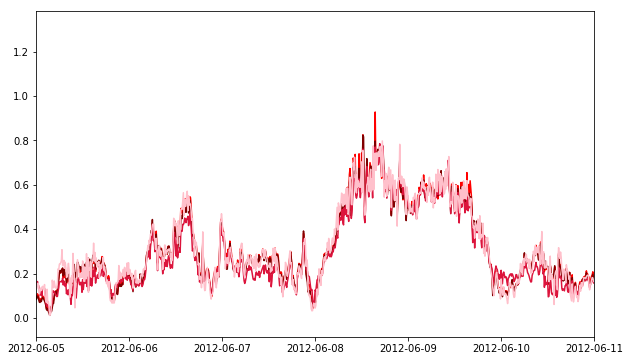

In [165]:
plt.figure(figsize=(10, 6))
#plt.pcolormesh(test_data.index, np.array([-1, 0.8]), 
#               np.where(test_data["zenith_0 m_degrees"] > 90, 1, 0).reshape(-1, 1).T, vmin=0, vmax=3, cmap="Greys")
plt.plot(slm_preds.index, slm_preds["friction_velocity-random_forest"], label=r"RF $u *$", color="red")
plt.plot(slm_preds.index, slm_preds["friction_velocity-neural_network"], label=r"NN $u *$", color="maroon")
plt.plot(slm_preds.index, slm_preds["friction_velocity-mo"], label=r"MO $u *$", color="crimson")
plt.plot(slm_preds.index, slm_preds["friction velocity_surface_m s-1"], label=r"MO $u *$", color="pink")

plt.xlim("2012-06-05", "2012-06-11")

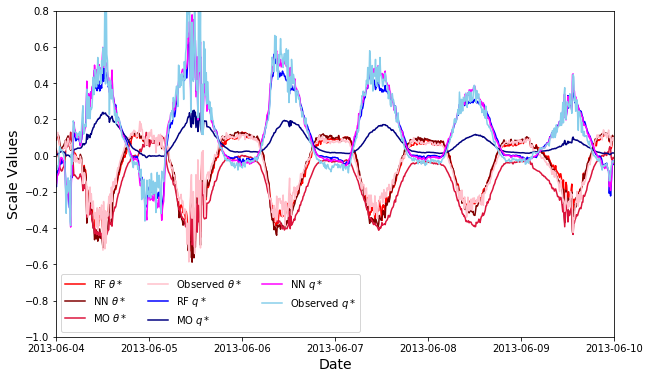

In [13]:
plt.figure(figsize=(10, 6))
#plt.pcolormesh(test_data.index, np.array([-1, 0.8]), 
#               np.where(test_data["zenith_0 m_degrees"] > 90, 1, 0).reshape(-1, 1).T, vmin=0, vmax=3, cmap="Greys")
plt.plot(slm_preds.index, slm_preds["temperature_scale-random_forest"], label=r"RF $\theta *$", color="red")
plt.plot(slm_preds.index, slm_preds["temperature_scale-neural_network"], label=r"NN $\theta *$", color="maroon")
plt.plot(slm_preds.index, slm_preds["temperature_scale-mo"], label=r"MO $\theta *$", color="crimson")

plt.plot(slm_preds.index, slm_preds["temperature scale_surface_K"], label=r"Observed $\theta*$", color="pink")
plt.plot(slm_preds.index, slm_preds["moisture_scale-random_forest"], label="RF $q*$", color="blue")
plt.plot(slm_preds.index, slm_preds["moisture_scale-mo"], label="MO $q*$", color="navy")
plt.plot(slm_preds.index, slm_preds["moisture_scale-neural_network"], label=r"NN $q *$", color="magenta")
plt.plot(slm_preds.index, slm_preds["moisture scale_surface_g kg-1"], label="Observed $q*$", color="skyblue")
#plt.plot(slm_preds.index, test_data["bulk richardson_10 m_"], color="green")

plt.xlim("2013-06-04", "2013-06-10")
plt.ylim(-1, 0.8)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Scale Values", fontsize=14)
plt.legend(ncol=3)
plt.savefig(join(model_path, "scale_ts.png"), dpi=200, bbox_inches="tight")

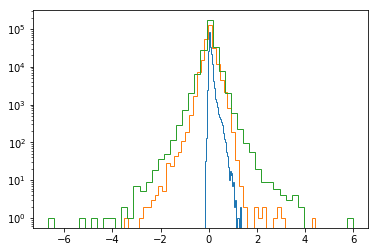

In [8]:
plt.hist(slm_preds["moisture_scale-mo"], bins=50, histtype="step")
plt.hist(slm_preds["moisture_scale-random_forest"], bins=50, histtype="step")
plt.hist(slm_preds["moisture scale_surface_g kg-1"], bins=50, histtype="step")

plt.gca().set_yscale("log")

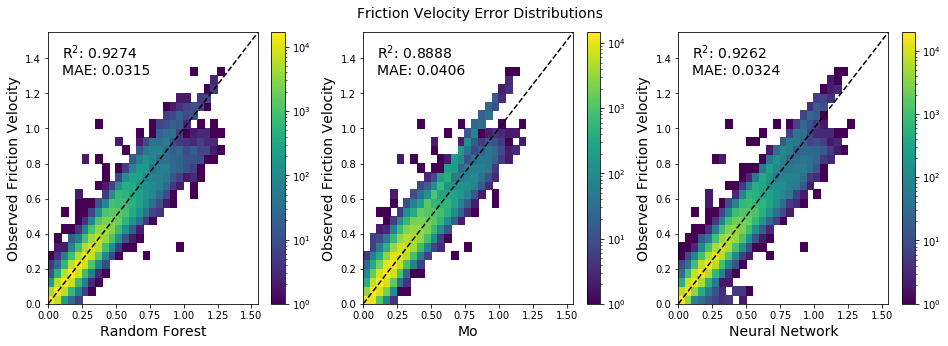

In [14]:
fig = plt.figure(figsize=(16, 5))
scale_bins = np.arange(0, 1.6, 0.05)
models = ["random_forest", "mo", "neural_network"]
output_label = "friction velocity_surface_m s-1"
output_type = "friction_velocity"
metric_loc = (0.1, 1.3)
for i in range(1, 4):
    plt.subplot(1, 3, i)

    _= plt.hist2d(slm_preds[output_type + "-" + models[i - 1]], 
               slm_preds[output_label], bins=scale_bins,
               norm=LogNorm(), cmin=1, cmap="viridis")
    plt.plot(scale_bins, scale_bins, 'k--')
    plt.xlabel(models[i-1].replace("_", " ").title(), fontsize=14)
    plt.ylabel(r"Observed " + output_type.replace("_", " ").title(), fontsize=14)
    plt.colorbar()
    r2_val = metrics.loc[output_type + "-" + models[i-1], "pearson_r2"]
    mae = metrics.loc[output_type + "-" + models[i-1], "mean_absolute_error"]
    plt.text(metric_loc[0], metric_loc[1], f"R$^2$: {r2_val:0.4f}\nMAE: {mae:0.4f}", fontsize=14)
fig.suptitle(output_type.replace("_", " ").title() + " Error Distributions", fontsize=14, y=0.95)
plt.savefig(join(model_path, output_type + "_errors.png"), dpi=200, bbox_inches="tight")
#plt.ylabel("Observed", fontsize=12)

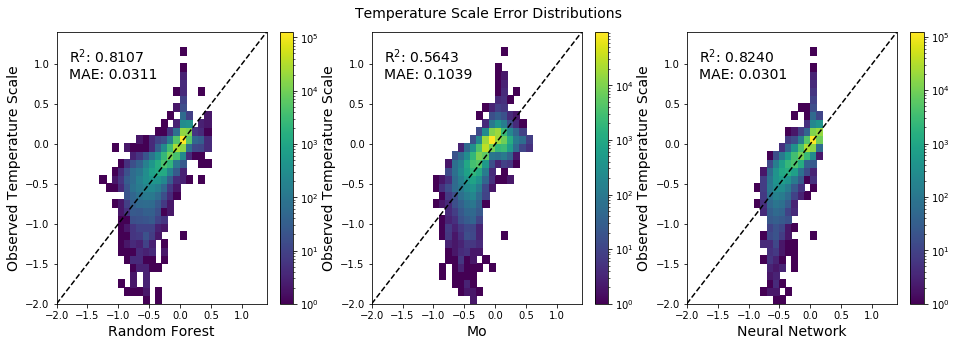

In [15]:
fig = plt.figure(figsize=(16, 5))
scale_bins = np.arange(-2, 1.5, 0.1)
models = ["random_forest", "mo", "neural_network"]
output_label = "temperature scale_surface_K"
output_type = "temperature_scale"
metric_loc = (-1.8, 0.8)
for i in range(1, 4):
    plt.subplot(1, 3, i)

    _= plt.hist2d(slm_preds[output_type + "-" + models[i - 1]], 
               slm_preds[output_label], bins=scale_bins,
               norm=LogNorm(), cmin=1, cmap="viridis")
    plt.plot(scale_bins, scale_bins, 'k--')
    plt.xlabel(models[i-1].replace("_", " ").title(), fontsize=14)
    plt.ylabel(r"Observed " + output_type.replace("_", " ").title(), fontsize=14)
    plt.colorbar()
    r2_val = metrics.loc[output_type + "-" + models[i-1], "pearson_r2"]
    mae = metrics.loc[output_type + "-" + models[i-1], "mean_absolute_error"]
    plt.text(metric_loc[0], metric_loc[1], f"R$^2$: {r2_val:0.4f}\nMAE: {mae:0.4f}", fontsize=14)
fig.suptitle(output_type.replace("_", " ").title() + " Error Distributions", fontsize=14, y=0.95)
plt.savefig(join(model_path, output_type + "_errors.png"), dpi=200, bbox_inches="tight")
#plt.ylabel("Observed", fontsize=12)

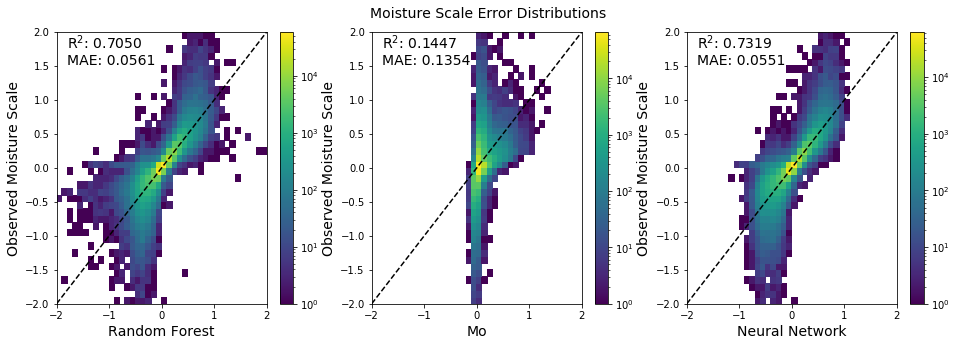

In [16]:
fig = plt.figure(figsize=(16, 5))
scale_bins = np.arange(-2, 2.1, 0.1)
models = ["random_forest", "mo", "neural_network"]
output_label = "moisture scale_surface_g kg-1"
output_type = "moisture_scale"
metric_loc = (-1.8, 1.5)
for i in range(1, 4):
    plt.subplot(1, 3, i)

    _= plt.hist2d(slm_preds[output_type + "-" + models[i - 1]], 
               slm_preds[output_label], bins=scale_bins,
               norm=LogNorm(), cmin=1, cmap="viridis")
    plt.plot(scale_bins, scale_bins, 'k--')
    plt.xlabel(models[i-1].replace("_", " ").title(), fontsize=14)
    plt.ylabel(r"Observed " + output_type.replace("_", " ").title(), fontsize=14)
    plt.colorbar()
    r2_val = metrics.loc[output_type + "-" + models[i-1], "pearson_r2"]
    mae = metrics.loc[output_type + "-" + models[i-1], "mean_absolute_error"]
    plt.text(metric_loc[0], metric_loc[1], f"R$^2$: {r2_val:0.4f}\nMAE: {mae:0.4f}", fontsize=14)
fig.suptitle(output_type.replace("_", " ").title() + " Error Distributions", fontsize=14, y=0.95)
plt.savefig(join(model_path, output_type + "_errors.png"), dpi=200, bbox_inches="tight")
#plt.ylabel("Observed", fontsize=12)

In [157]:
slm_preds["moisture_scale-mo"].max()

3.6426282

In [134]:
stable = test_data["bulk richardson_10 m_"] > 0.1
unstable = test_data["bulk richardson_10 m_"] < -0.1
print(mean_absolute_error(slm_preds.loc[stable, "temperature scale_surface_K"], 
                    slm_preds.loc[stable, "temperature_scale-random_forest"]))
print(mean_absolute_error(slm_preds.loc[stable, "temperature scale_surface_K"], 
                    slm_preds.loc[stable, "temperature_scale-neural_network"]))
print(mean_absolute_error(slm_preds.loc[stable, "temperature scale_surface_K"], 
                    slm_preds.loc[stable, "temperature_scale-mo"]))
print(mean_absolute_error(slm_preds.loc[stable, "temperature scale_surface_K"].values, 
                    np.ones(stable.sum()) * slm_preds.loc[stable, "temperature scale_surface_K"].mean()))
print(mean_absolute_error(slm_preds.loc[unstable, "temperature scale_surface_K"], 
                    slm_preds.loc[unstable, "temperature_scale-random_forest"]))
print(mean_absolute_error(slm_preds.loc[unstable, "temperature scale_surface_K"], 
                    slm_preds.loc[unstable, "temperature_scale-neural_network"]))
print(mean_absolute_error(slm_preds.loc[unstable, "temperature scale_surface_K"], 
                    slm_preds.loc[unstable, "temperature_scale-mo"]))
print(mean_absolute_error(slm_preds.loc[unstable, "temperature scale_surface_K"].values, 
                    np.ones(unstable.sum()) * slm_preds.loc[unstable, "temperature scale_surface_K"].mean()))


0.039570421440669065
0.03772249650603846
0.08944540892455731
0.046920570375442644
0.047858585615480724
0.04594581114145559
0.10826870216924872
0.13326155853616212


In [13]:
1 - 0.038 / 0.0469

0.18976545842217485

In [14]:
1 - 0.047 / 0.133

0.6466165413533835

In [97]:
cp = 1005.0
Le = 2500
k = 0.4
z = 10.0
sensible_heat_rf = -cp * slm_preds["air density_10 m_kg m-3"] * slm_preds["temperature_scale_random_forest"] * slm_preds["friction_velocity_random_forest"]
latent_heat_rf = Le * slm_preds["air density_10 m_kg m-3"] * slm_preds["friction_velocity_random_forest"] * slm_preds["moisture_scale_random_forest"]
z_over_l = k * z * 9.81 / test_data["potential temperature_10 m_K"].values *  slm_preds["temperature_scale_random_forest"].values / (
    slm_preds["friction_velocity_random_forest"].values ** 2)
z_over_l_true = k * z * 9.81 / test_data["potential temperature_10 m_K"].values * slm_preds["temperature scale_surface_K"] / (
    slm_preds["friction velocity_surface_m s-1"].values ** 2)


In [88]:
slm_preds["temperature_scale_random_forest"][0]

0.07620097722380816

In [73]:
(10.0 / slm_preds["obukhov length_surface_m"].values).max()

1899.4734089868268

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan,  1., nan],
        ...,
        [nan, nan,  1., ..., nan, nan, nan],
        [ 1., nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19]),
 <matplotlib.collections.QuadMesh at 0x137c11eb8>)

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


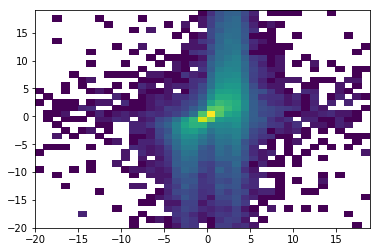

In [100]:
plt.hist2d(z_over_l, z_over_l_true, bins=np.arange(-20, 20), cmin=1, norm=LogNorm())

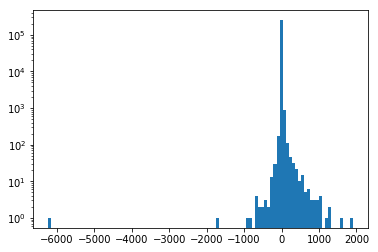

In [77]:
plt.hist(10.0 / slm_preds["obukhov length_surface_m"], bins=100)
plt.gca().set_yscale("log")

(734662.0, 734666.0)

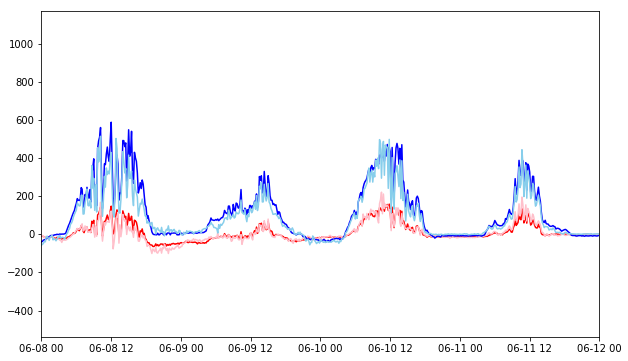

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(slm_preds.index, sensible_heat_rf, color="red")
plt.plot(slm_preds.index, slm_preds["sensible heat flux_surface_W m-2"], color="pink")
plt.plot(slm_preds.index, latent_heat_rf, color="blue")
plt.plot(slm_preds.index, slm_preds["latent heat flux_surface_W m-2"], color="skyblue")
plt.xlim("2012-06-08", "2012-06-12")
#plt.ylim(-1, 1)

(-200, 400)

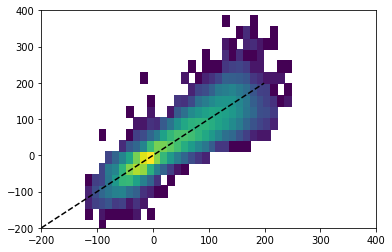

In [56]:
plt.hist2d(sensible_heat_rf, slm_preds["sensible heat flux_surface_W m-2"], 
           cmin=1, bins=30, norm=LogNorm())
plt.plot(np.arange(-200, 200), np.arange(-200, 200), 'k--')
plt.xlim(-200, 400)
plt.ylim(-200, 400)

In [46]:
slm_preds["latent heat flux_surface_W m-2"].max()

628.1343

(array([8.3185e+04, 7.7975e+04, 5.5046e+04, 2.3876e+04, 7.7490e+03,
        2.4650e+03, 9.5100e+02, 3.6500e+02, 1.4400e+02, 4.9000e+01]),
 array([0.03116889, 0.15564919, 0.28012949, 0.40460979, 0.52909009,
        0.65357039, 0.77805069, 0.902531  , 1.0270113 , 1.1514916 ,
        1.2759719 ]),
 <a list of 10 Patch objects>)

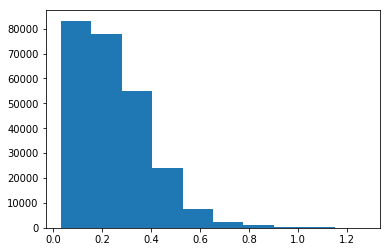

In [4]:
plt.hist(slm_preds["friction_velocity_random_forest"])

(array([6.9699e+04, 8.4787e+04, 5.8871e+04, 2.5936e+04, 8.3150e+03,
        2.8060e+03, 1.0010e+03, 2.7500e+02, 1.0200e+02, 1.3000e+01]),
 array([1.00000000e-03, 1.32281270e-01, 2.63562540e-01, 3.94843810e-01,
        5.26125080e-01, 6.57406350e-01, 7.88687620e-01, 9.19968890e-01,
        1.05125016e+00, 1.18253143e+00, 1.31381270e+00]),
 <a list of 10 Patch objects>)

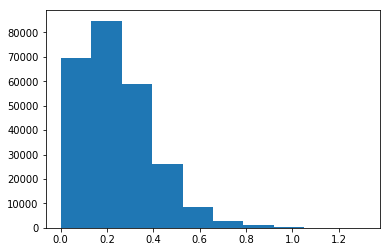

In [5]:
plt.hist(slm_preds["friction velocity_surface_m s-1"])

In [18]:
with open("../config/surface_layer_training.yml") as config_file:
    config = yaml.load(config_file)
    

In [29]:
config

{'data_file': '/Users/dgagne/data/cabauw_derived_data_20190312.csv',
 'out_dir': '/Users/dgagne/data/cabauw_surface_layer_models_20190419/',
 'train_test_split_date': '2011-01-01',
 'output_types': ['friction_velocity', 'temperature_scale', 'moisture_scale'],
 'model_metric_types': ['mean_squared_error',
  'mean_absolute_error',
  'mean_error',
  'pearson_r2',
  'hellinger_distance'],
 'input_columns': {'friction_velocity': ['wind speed_10 m_m s-1',
   'wind speed_20 m_m s-1',
   'pressure_2 m_hPa',
   'temperature change_15 m_K m-1',
   'skin virtual potential temperature_0 m_K',
   'global horizontal irradiance_0 m_W m-2',
   'virtual potential temperature_10 m_K',
   'virtual potential temperature_20 m_K',
   'bulk richardson_10 m_',
   'zenith_0 m_degrees'],
  'temperature_scale': ['wind speed_10 m_m s-1',
   'wind speed_20 m_m s-1',
   'pressure_2 m_hPa',
   'temperature change_15 m_K m-1',
   'skin virtual potential temperature_0 m_K',
   'skin saturation mixing ratio_0 m_g kg-1'

In [30]:
input_cols = config["input_columns"]
output_cols = config["output_columns"]

In [111]:
scalers = dict()
for output_type in config["output_types"]:
    with open(join(model_path, output_type + "_scaler.pkl"), "rb") as sc_pkl:
        scalers[output_type] = pickle.load(sc_pkl)

In [109]:
random_forests = dict()
neural_nets = dict()
for output_type in config["output_types"]:
    with open(join(model_path, output_type + "-random_forest.pkl"), "rb") as rf_pkl:
        random_forests[output_type] = pickle.load(rf_pkl)
    neural_nets[output_type] = load_model(join(model_path, output_type + "-neural_network.h5"))

In [22]:
sub_indices = np.arange(test_data.shape[0])
sub_indices = np.random.permutation(sub_indices)[:20000]
sub_test = test_data.iloc[sub_indices]

In [214]:
sub_test.min()

global horizontal irradiance_0 m_W m-2      -5.565070
zenith_0 m_degrees                          28.540651
azimuth_0 m_degrees                          0.001676
temperature_2 m_K                          253.950000
temperature_10 m_K                         259.050000
temperature_20 m_K                         259.850000
temperature_40 m_K                         259.750000
pressure_2 m_hPa                           971.400000
potential temperature_2 m_K                251.099449
potential temperature_10 m_K               256.142203
potential temperature_20 m_K               256.897951
potential temperature_40 m_K               256.799087
virtual potential temperature_2 m_K        251.193910
virtual potential temperature_10 m_K       256.301039
virtual potential temperature_20 m_K       257.017327
virtual potential temperature_40 m_K       256.915360
mixing ratio_2 m_g kg-1                      0.027474
mixing ratio_10 m_g kg-1                     0.021653
mixing ratio_20 m_g kg-1    

In [131]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    pd_sd = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        preds = model.predict(x_copy)
        partial_dependence[v] = preds.mean()
        pd_sd[v] = preds.std()
    return partial_dependence, pd_sd

In [132]:
pd_points = 20
pd_vals_rf = {}
pd_sd_rf = {}
pd_in = {}
pd_in_rf = {}
pd_vals_nn = {}
pd_sd_nn = {}
for output_type in config["output_types"]:
    print(output_type)
    scaled_sub = scalers[output_type].transform(sub_test[input_cols[output_type]])
    print(scaled_sub.min(axis=1))
    pd_in[output_type] = np.zeros((len(input_cols[output_type]), pd_points))
    pd_in_rf[output_type] = np.zeros((len(input_cols[output_type]), pd_points))

    pd_vals_rf[output_type] = np.zeros((len(input_cols[output_type]), pd_points))
    pd_sd_rf[output_type] = np.zeros((len(input_cols[output_type]), pd_points))

    pd_vals_nn[output_type] = np.zeros((len(input_cols[output_type]), pd_points))
    pd_sd_nn[output_type] = np.zeros((len(input_cols[output_type]), pd_points))
    for i, input_col in enumerate(input_cols[output_type]):
        print(input_col)
        pd_in[output_type][i] = np.linspace(scaled_sub[:, i].min(), 
                                            scaled_sub[:, i].max(), pd_points)
        pd_in_rf[output_type][i] = np.linspace(sub_test[input_col].min(), 
                                            sub_test[input_col].max(), pd_points)
        pd_vals_rf[output_type][i], pd_sd_rf[output_type][i] = partial_dependence_1d(sub_test[input_cols[output_type]], 
                                                           random_forests[output_type], 
                                                           i, pd_in_rf[output_type][i])
        pd_vals_nn[output_type][i], pd_sd_nn[output_type][i] = partial_dependence_1d(scaled_sub, 
                                                           neural_nets[output_type], 
                                                           i, pd_in[output_type][i])

friction_velocity
[-6.45076906 -0.94413885 -1.2612588  ... -1.07663111 -1.72553481
 -1.14808863]
wind speed_10 m_m s-1
wind speed_20 m_m s-1
pressure_2 m_hPa
temperature change_15 m_K m-1
skin virtual potential temperature_0 m_K
global horizontal irradiance_0 m_W m-2
virtual potential temperature_10 m_K
virtual potential temperature_20 m_K
bulk richardson_10 m_
zenith_0 m_degrees
temperature_scale
[-6.45076906 -1.35593141 -1.40997332 ... -1.07663111 -1.72553481
 -1.14808863]
wind speed_10 m_m s-1
wind speed_20 m_m s-1
pressure_2 m_hPa
temperature change_15 m_K m-1
skin virtual potential temperature_0 m_K
skin saturation mixing ratio_0 m_g kg-1
global horizontal irradiance_0 m_W m-2
virtual potential temperature_10 m_K
virtual potential temperature_20 m_K
moisture availability_3 cm_
bulk richardson_10 m_
zenith_0 m_degrees
moisture_scale
[-6.45076906 -1.35593141 -1.40997332 ... -1.07663111 -1.72553481
 -1.14808863]
wind speed_10 m_m s-1
wind speed_20 m_m s-1
pressure_2 m_hPa
temperature

In [122]:
pd_vals_rf["moisture_scale"].shape

(14, 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


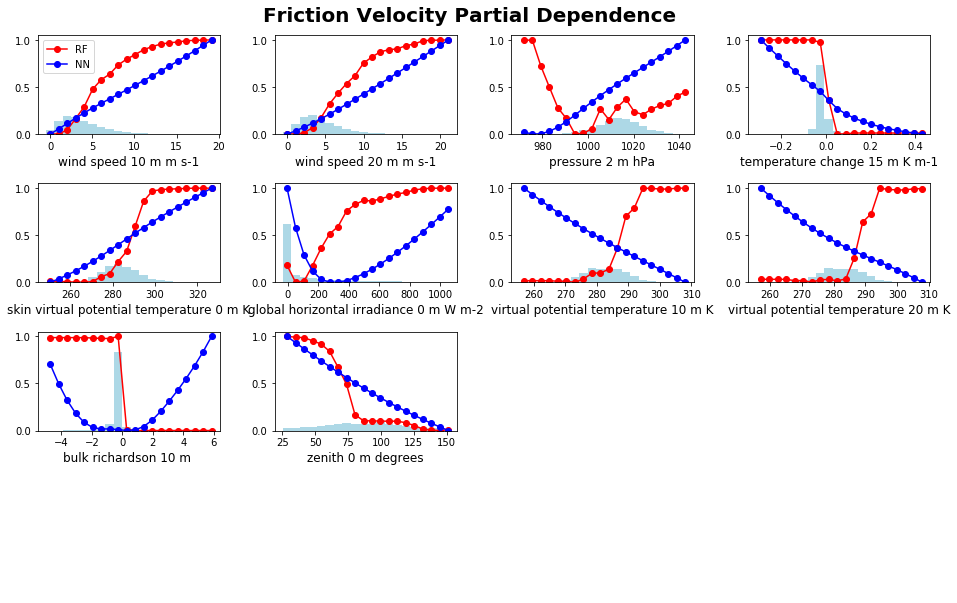

In [144]:
fig, axes = plt.subplots(4, 4, figsize=(16, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
output_type= "friction_velocity"
un_scaled_in = scalers[output_type].inverse_transform(pd_in[output_type].T).T
for a, ax in enumerate(axes.ravel()):
    print(a)
    if a < len(input_cols[output_type]):
        rf_pd_col = (pd_vals_rf[output_type][a] - pd_vals_rf[output_type][a].min()) / (
            pd_vals_rf[output_type][a].max() - pd_vals_rf[output_type][a].min())
        #rf_pd_col_sd = (pd_sd_rf[output_type][a] - pd_vals_rf[output_type][a].min()) / (
        #    pd_vals_rf[output_type][a].max() - pd_vals_rf[output_type][a].min())
        nn_pd_col = (pd_vals_nn[output_type][a] - pd_vals_nn[output_type][a].min()) / (
            pd_vals_nn[output_type][a].max() - pd_vals_nn[output_type][a].min())
        #ax.fill_between(un_scaled_in[a], rf_pd_col_sd + rf_pd_col, -rf_pd_col_sd + rf_pd_col, color='r', alpha=0.5)
        ax.plot(un_scaled_in[a], rf_pd_col, 'ro-', label="RF")
        ax.plot(un_scaled_in[a], nn_pd_col, 'bo-', label="NN")

        ax.set_xlabel(input_cols[output_type][a].replace("_", " "), fontsize=12)
        in_hist, _ = np.histogram(sub_test[input_cols[output_type][a]], bins=un_scaled_in[a])
        ax.bar(un_scaled_in[a, :-1], 
               height=in_hist / in_hist.sum(), 
               width=un_scaled_in[a, 1:] - un_scaled_in[a, :-1], bottom=0, 
                                        color='lightblue')
        if a == 0:
            ax.legend()
    else:
        ax.axis("off")
fig.suptitle(output_type.replace("_", " ").title() + " Partial Dependence", fontsize=20, fontweight="bold", y=0.92)
plt.savefig(join(model_path, output_type + "_pdp.png"), dpi=200, bbox_inches="tight")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


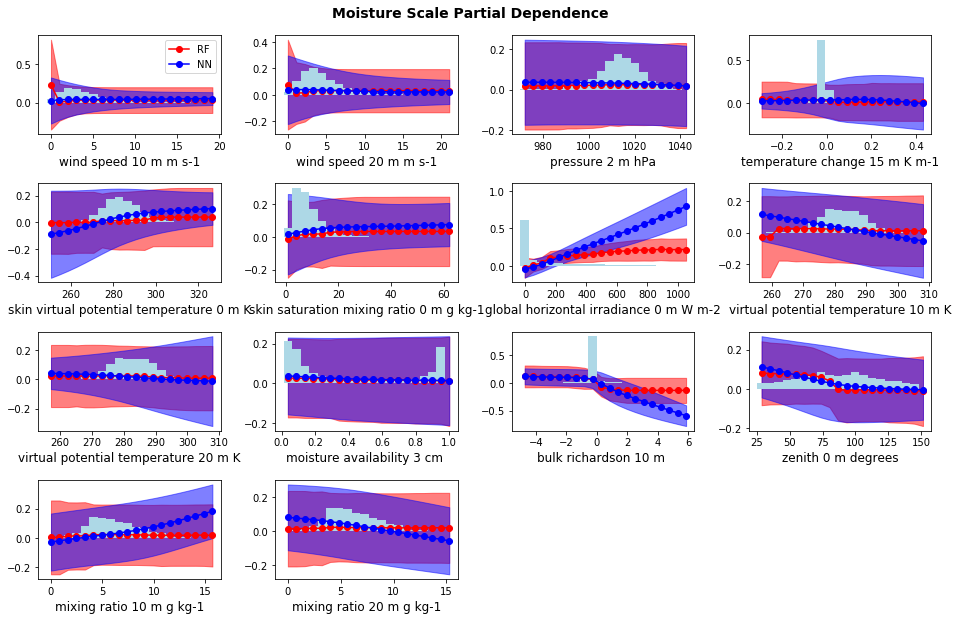

In [143]:
fig, axes = plt.subplots(4, 4, figsize=(16, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
output_type= "moisture_scale"
un_scaled_in = scalers[output_type].inverse_transform(pd_in[output_type].T).T
for a, ax in enumerate(axes.ravel()):
    print(a)
    if a < len(input_cols[output_type]):
        #rf_pd_col = (pd_vals_rf[output_type][a] - pd_vals_rf[output_type][a].min()) / (
        #    pd_vals_rf[output_type][a].max() - pd_vals_rf[output_type][a].min())
        #rf_pd_col_sd = (pd_sd_rf[output_type][a] - pd_vals_rf[output_type][a].min()) / (
        #    pd_vals_rf[output_type][a].max() - pd_vals_rf[output_type][a].min())
        #nn_pd_col = (pd_vals_nn[output_type][a] - pd_vals_nn[output_type][a].min()) / (
        #    pd_vals_nn[output_type][a].max() - pd_vals_nn[output_type][a].min())
        ax.fill_between(un_scaled_in[a], pd_vals_rf[output_type][a] + pd_sd_rf[output_type][a], 
                        pd_vals_rf[output_type][a] - pd_sd_rf[output_type][a], color='r', alpha=0.5)
        ax.fill_between(un_scaled_in[a], pd_vals_nn[output_type][a] + pd_sd_nn[output_type][a], 
                        pd_vals_nn[output_type][a] - pd_sd_nn[output_type][a], color='b', alpha=0.5)
        ax.plot(un_scaled_in[a], pd_vals_rf[output_type][a], 'ro-', label="RF")
        ax.plot(un_scaled_in[a], pd_vals_nn[output_type][a], 'bo-', label="NN")

        ax.set_xlabel(input_cols[output_type][a].replace("_", " "), fontsize=12)
        in_hist, _ = np.histogram(sub_test[input_cols[output_type][a]], bins=un_scaled_in[a])
        ax.bar(un_scaled_in[a, :-1], 
               height=in_hist / in_hist.sum(), 
               width=un_scaled_in[a, 1:] - un_scaled_in[a, :-1], bottom=0, 
                                        color='lightblue')
        if a == 0:
            ax.legend()
    else:
        ax.axis("off")
fig.suptitle(output_type.replace("_", " ").title() + " Partial Dependence", fontsize=14, fontweight="bold", y=0.92)
plt.savefig(join(model_path, output_type + "_pdp_full.png"), dpi=200, bbox_inches="tight")


In [244]:
class MORegressor(object):
    def __init__(self, out_index=0):
        self.out_index = out_index
        return
    
    def predict(self, x):
        outputs = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            outputs[i] = mo_similarity(*x[i])[self.out_index]
        return outputs

In [237]:
mo_input_cols = ['u wind_10 m_m s-1', 'v wind_10 m_m s-1', 
                 'skin temperature_0 m_K', 'temperature_2 m_K',
                'skin saturation mixing ratio_0 m_g kg-1', 'mixing ratio_2 m_g kg-1',
                 'pressure_2 m_hPa', 'moisture availability_3 cm_']
mo_test_data = test_data[mo_input_cols]
mo_test_data.loc[:, 'skin saturation mixing ratio_0 m_g kg-1'] = mo_test_data.loc[:, 'skin saturation mixing ratio_0 m_g kg-1']/ 1000
mo_test_data.loc[:, 'mixing ratio_2 m_g kg-1'] = mo_test_data.loc[:, 'mixing ratio_2 m_g kg-1'] / 1000

In [239]:
mo_test_data = mo_test_data.iloc[sub_indices]

In [246]:
pd_vals_mo = {}
pd_in_mo = {}
for o, output_type in enumerate(config["output_types"]):
    print(output_type)
    pd_in_mo[output_type] = np.zeros((len(mo_input_cols), pd_points))
    pd_vals_mo[output_type] = np.zeros((len(mo_input_cols), pd_points))
    for i, input_col in enumerate(mo_input_cols):
        print(input_col)
        mo_mod = MORegressor(o)
        pd_in_mo[output_type][i] = np.linspace(mo_test_data.iloc[:, i].min(), 
                                            mo_test_data.iloc[:, i].max(), pd_points)
        pd_vals_mo[output_type][i] = partial_dependence_1d(mo_test_data.values, 
                                                           mo_mod, 
                                                           i, pd_in_mo[output_type][i])

friction_velocity
u wind_10 m_m s-1
v wind_10 m_m s-1
skin temperature_0 m_K
temperature_2 m_K
skin saturation mixing ratio_0 m_g kg-1
mixing ratio_2 m_g kg-1
pressure_2 m_hPa
moisture availability_3 cm_
temperature_scale
u wind_10 m_m s-1
v wind_10 m_m s-1
skin temperature_0 m_K
temperature_2 m_K
skin saturation mixing ratio_0 m_g kg-1
mixing ratio_2 m_g kg-1
pressure_2 m_hPa
moisture availability_3 cm_
moisture_scale
u wind_10 m_m s-1
v wind_10 m_m s-1
skin temperature_0 m_K
temperature_2 m_K
skin saturation mixing ratio_0 m_g kg-1
mixing ratio_2 m_g kg-1
pressure_2 m_hPa
moisture availability_3 cm_


0
1
2
3
4
5
6
7


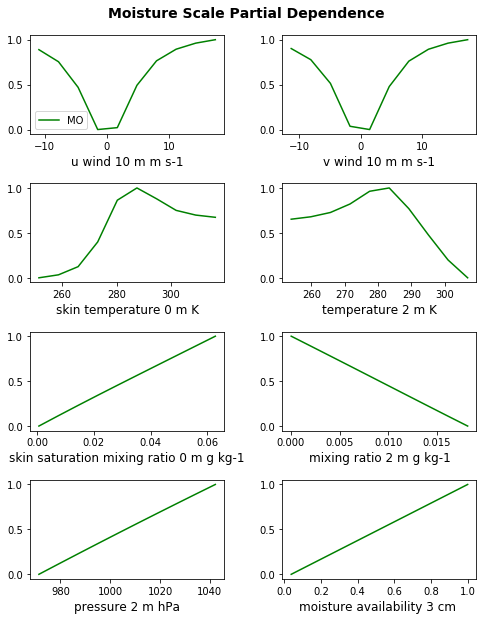

In [258]:
fig, axes = plt.subplots(4, 2, figsize=(8, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
output_type= "moisture_scale"
for a, ax in enumerate(axes.ravel()):
    print(a)
    if a < len(input_cols[output_type]):
        mo_pd_col = (pd_vals_mo[output_type][a] - pd_vals_mo[output_type][a].min()) / (
            pd_vals_mo[output_type][a].max() - pd_vals_mo[output_type][a].min())
        #mo_pd_col = pd_vals_mo[output_type][a]
        ax.plot(pd_in_mo[output_type][a], mo_pd_col, 'g-', label="MO")

        ax.set_xlabel(mo_input_cols[a].replace("_", " "), fontsize=12)
        #in_hist, _ = np.histogram(mo_test[mo_input_cols[output_type][a]], bins=un_scaled_in[a])
        #ax.bar(un_scaled_in[a, :-1], 
        #       height=in_hist / in_hist.sum(), 
        #       width=un_scaled_in[a, 1:] - un_scaled_in[a, :-1], bottom=0, 
        #                                color='lightblue')
        if a == 0:
            ax.legend()
    else:
        ax.axis("off")
fig.suptitle(output_type.replace("_", " ").title() + " Partial Dependence", fontsize=14, fontweight="bold", y=0.92)
plt.savefig(join(model_path, output_type + "_pdp_mo.png"), dpi=200, bbox_inches="tight")


In [106]:
import traceback
def feature_importance(x, y, model, metric_function, x_columns=None, permutations=30, processes=1, seed=8272):
    """
    Calculate permutation feature importance scores for an arbitrary machine learning model.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        x_columns (ndarray or None): list or array of column names. If not provided, indices will be used instead.
        permutations (int): Number of times a column is randomly shuffled.
        processes (int): Number of multiprocessor processes used for parallel computation of importances
        seed (int): Random seed.

    Returns:
        pandas DataFrame of dimension (n_columns, permutations) that contains the change in score
        for each column and permutation.
    """
    if x_columns is None:
        x_columns = np.arange(x.shape[1])
    if type(x_columns) == list:
        x_columns = np.array(x_columns)
    predictions = model.predict(x)
    score = metric_function(y, predictions)
    print(score)
    np.random.seed(seed=seed)
    perm_matrix = np.zeros((x_columns.shape[0], permutations))

    def update_perm_matrix(result):
        perm_matrix[result[0]] = result[1]
    if processes > 1:
        pool = Pool(processes)
        for c in range(len(x_columns)):
            pool.apply_async(feature_importance_column,
                             (x, y, c, permutations, deepcopy(model), metric_function, np.random.randint(0, 100000)),
                              callback=update_perm_matrix)
        pool.close()
        pool.join()
    else:
        for c in range(len(x_columns)):
            result = feature_importance_column(x, y, c, permutations, model,
                                               metric_function, np.random.randint(0, 100000))
            update_perm_matrix(result)
    diff_matrix = score - perm_matrix
    return pd.DataFrame(diff_matrix, index=x_columns, columns=np.arange(permutations))


def feature_importance_column(x, y, column_index, permutations, model, metric_function, seed):
    """
    Calculate the permutation feature importance score for a single input column. It is the error score on
    a given set of data after the values in one column have been shuffled among the different examples.

    Args:
        x: ndarray of dimension (n_examples, n_features) that contains the input data for the ML model.
        y: ndarray of dimension (n_examples, ) that contains the true target values.
        column_index: Index of the x column being permuted
        permutations: Number of permutations run to calculate importance score distribution
        model: machine learning model object in scikit-learn format (contains fit and predict methods).
        metric_function: scoring function with the input format (y_true, y_predicted) to match scikit-learn.
        seed (int): random seed.

    Returns:
        column_index, permutation, perm_score
    """
    try:
        #rs = np.random.RandomState(seed=seed)
        indices = np.arange(x.shape[0])
        perm_scores = np.zeros(permutations)
        x_perm = np.copy(x)
        x_pred = model.predict(x)
        for p in range(permutations):
            print(column_index, p)
            perm_indices = np.random.permutation(indices)
            x_perm[:, column_index] = x[perm_indices, column_index]
            perm_pred = model.predict(x_perm)
            perm_scores[p] = metric_function(y, perm_pred)
            print(perm_scores[p])
        return column_index, perm_scores
    except Exception as e:
        print(traceback.format_exc())
        raise e

In [124]:
output_type = "moisture_scale"
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rf_imp = feature_importance(train_data[input_cols[output_type]].values, train_data[output_cols[output_type]].values, 
                   random_forests[output_type], rmse, x_columns=input_cols[output_type], permutations=1)

0.10658335519033461
0 0
0.14536104740999164
1 0
0.1382020536810296
2 0
0.11923982436838104
3 0
0.13530606607617646
4 0
0.130350556263972
5 0
0.12496433740101752
6 0
0.19682829760655485
7 0
0.12388064217337276
8 0
0.12023848726080978
9 0
0.12672992114416315
10 0
0.16384434473455084
11 0
0.14534076252404005
12 0
0.11902684573784085
13 0
0.11681071303461739


In [126]:
rf_imp.sort_values(by=0)

,0
global horizontal irradiance_0 m_W m-2,-0.090245
bulk richardson_10 m_,-0.057261
wind speed_10 m_m s-1,-0.038778
zenith_0 m_degrees,-0.038757
wind speed_20 m_m s-1,-0.031619
temperature change_15 m_K m-1,-0.028723
skin virtual potential temperature_0 m_K,-0.023767
moisture availability_3 cm_,-0.020147
skin saturation mixing ratio_0 m_g kg-1,-0.018381
virtual potential temperature_10 m_K,-0.017297


In [129]:
pd.DataFrame(random_forests[output_type].feature_importances_, index=input_cols[output_type]).sort_values(by=0)[::-1]

,0
global horizontal irradiance_0 m_W m-2,0.216748
bulk richardson_10 m_,0.163865
zenith_0 m_degrees,0.128889
temperature change_15 m_K m-1,0.095639
wind speed_10 m_m s-1,0.064468
skin saturation mixing ratio_0 m_g kg-1,0.061715
skin virtual potential temperature_0 m_K,0.059160
wind speed_20 m_m s-1,0.056278
virtual potential temperature_10 m_K,0.034400
virtual potential temperature_20 m_K,0.033658


In [45]:
sub_test[input_cols[output_type]].values[:, -1].min()

28.539912717676987